In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from functools import partial

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
from metal.mmtl.metal_model import MetalModel
from metal.mmtl.slicing.slice_model import SliceModel
from metal.mmtl.trainer import MultitaskTrainer
from metal.mmtl.slicing.synthetics.mmtl_utils import create_tasks, create_payloads
from metal.mmtl.slicing.synthetics.data_generator import generate_data, get_circle_mask
from metal.mmtl.slicing.synthetics.viz import visualize_payload, visualize_predictions

In [5]:
# choices -> 'naive', hard_param', 'soft_param'
MODEL_NAME = 'naive'

### Generate Synthetic Dataset
We aim to build a dataset with a linear decision boundary and an abnormal boundary around $x=0.3, y=0$.
We define this slice as our `critical_region`.

In [6]:
# define slice fns
identity_fn = lambda x: torch.from_numpy(np.ones(x.shape[0], dtype=np.uint8))

In [7]:
critical_slice_indicator = partial(get_circle_mask, center=(0.25, 0), radius=0.2)
uid_lists, Xs, Ys = generate_data(N=2000, critical_slice_indicator=critical_slice_indicator)
task_name = "test_task"

#### Generate eval payload over the `critical_slice`

In [8]:
eval_payload = create_payloads(task_name, uid_lists, Xs, Ys, batch_size=4, 
   slice_funcs={"critical_slice": critical_slice_indicator}
)[2] # take test set

Vizualizing labelset_gold from payload_test...


/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


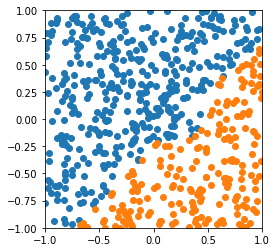

Vizualizing labelset:critical_slice from payload_test...


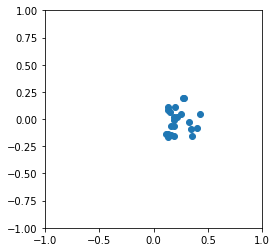

In [9]:
visualize_payload(eval_payload)

### Create tasks and payloads

In [10]:
critical_slice_fn = partial(get_circle_mask, center=(0.4, 0), radius=0.3)
if MODEL_NAME == 'naive':
    slice_funcs = {"BASE": identity_fn}
    model_class = MetalModel
elif MODEL_NAME == 'hard_param':
    slice_funcs = {"critical_slice": critical_slice_fn, "BASE": identity_fn}
    model_class = MetalModel
elif MODEL_NAME == 'soft_param':
    slice_funcs = {"critical_slice": critical_slice_fn, "BASE": identity_fn}
    model_class = SliceModel
else:
    raise ValueError(f"{MODEL_NAME} model not defined.")

In [11]:
tasks = create_tasks(task_name, slice_names=list(slice_funcs.keys()))
tasks

[BinaryClassificationTask(name=test_task, loss_multiplier=1.00, is_slice=False),
 BinaryClassificationTask(name=test_task:BASE, loss_multiplier=1.00, is_slice=True)]

In [12]:
payloads = create_payloads(task_name, uid_lists, Xs, Ys, batch_size=4, slice_funcs=slice_funcs)
payloads

[Payload(payload_train: labels_to_tasks=[{'labelset_gold': 'test_task', 'labelset:BASE': 'test_task:BASE'}], split=train),
 Payload(payload_valid: labels_to_tasks=[{'labelset_gold': 'test_task', 'labelset:BASE': 'test_task:BASE'}], split=valid),
 Payload(payload_test: labels_to_tasks=[{'labelset_gold': 'test_task', 'labelset:BASE': 'test_task:BASE'}], split=test)]

#### Visualize Train Payloads

Vizualizing labelset_gold from payload_train...


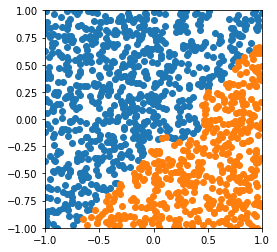

Vizualizing labelset:BASE from payload_train...


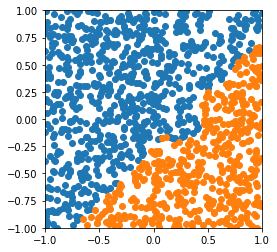

In [13]:
visualize_payload(payloads[0])

## Define Model

In [14]:
model = model_class(tasks, verbose=True)

No cuda device available. Using cpu instead.

Network architecture:
MetalModel(
  (input_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Linear(in_features=2, out_features=8, bias=True)
      )
    )
    (test_task:BASE): DataParallel(
      (module): MetalModuleWrapper(
        (module): Linear(in_features=2, out_features=8, bias=True)
      )
    )
  )
  (middle_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): IdentityModule()
      )
    )
    (test_task:BASE): DataParallel(
      (module): MetalModuleWrapper(
        (module): IdentityModule()
      )
    )
  )
  (attention_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): IdentityModule()
      )
    )
    (test_task:BASE): DataParallel(
      (module): MetalModuleWrapper(
        (module): IdentityModule()
      )
    )
  )
  (head_modules): ModuleDict(
    (

## Train model!

In [15]:
trainer = MultitaskTrainer(verbose=False, lr=0.01)

In [16]:
metrics_dict = trainer.train_model(
    model, payloads, verbose=True,
    n_epochs=20
)

Beginning train loop.
Expecting a total of approximately 1200 examples and 300 batches per epoch from 1 payload(s) in the train split.


/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1.0 epo]: test_task:[payload_train/labelset_gold/loss=2.00e-01, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:BASE:[payload_train/labelset:BASE/loss=2.01e-01, payload_valid/labelset:BASE/accuracy=9.70e-01] model:[train/all/loss=2.01e-01, train/all/lr=1.00e-02]
[2.0 epo]: test_task:[payload_train/labelset_gold/loss=8.63e-02, payload_valid/labelset_gold/accuracy=9.75e-01] test_task:BASE:[payload_train/labelset:BASE/loss=8.65e-02, payload_valid/labelset:BASE/accuracy=9.75e-01] model:[train/all/loss=8.64e-02, train/all/lr=1.00e-02]
[3.0 epo]: test_task:[payload_train/labelset_gold/loss=7.63e-02, payload_valid/labelset_gold/accuracy=9.75e-01] test_task:BASE:[payload_train/labelset:BASE/loss=7.64e-02, payload_valid/labelset:BASE/accuracy=9.75e-01] model:[train/all/loss=7.64e-02, train/all/lr=1.00e-02]
[4.0 epo]: test_task:[payload_train/labelset_gold/loss=7.38e-02, payload_valid/labelset_gold/accuracy=9.75e-01] test_task:BASE:[payload_train/labelset:BASE/loss=7.38e-02, payload_va

**NOTE**: Ensure that slice labelsets are evaluated on the primary task head.

## Evaluate Model

In [17]:
test_labelsets = eval_payload.labels_to_tasks.keys()
for label_name in test_labelsets:
    eval_payload.retarget_labelset(label_name, 'test_task')

label_set labelset_gold now points to task test_task (originally, test_task).
label_set labelset:critical_slice now points to task test_task (originally, test_task:critical_slice).


In [18]:
model.score(eval_payload)

{'test_task/payload_test/labelset_gold/accuracy': 0.965,
 'test_task/payload_test/labelset:critical_slice/accuracy': 0.6363636363636364}

Evaluate a specific main task head on separate labelsets

### Visualize Predictions

Vizualizing MetalModel predictions on labelset_gold...


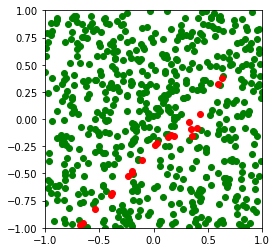

Vizualizing MetalModel predictions on labelset:critical_slice...


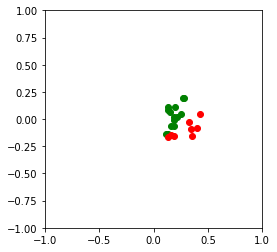

In [19]:
visualize_predictions(model, eval_payload)